In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data (just after splitting)
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

# Load full data

x_train_full = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
#y_train_full = np.load('./data/labels/train_labels_augmented4.npy')
#x_test = np.load('./data/images/time_norm_test_images.npy')[:,0,:,:]
#y_test = np.load('./data/labels/test_labels.npy')

In [9]:
less_indexes = np.random.choice(np.arange(len(train_labels)), int(0.1 * len(train_labels)), replace=False)

train_tracks[less_indexes][:,0,4:17].shape

(110, 13)

In [ ]:
dataset_size = [0.1, 0.2, 0.3] # will probably have to try with different seeds #, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

# Will use frame 0

#### FIGURE OUT WHY IT'S NOT WORKING FOR THE NEXT SIZE, AND WHY THE TABULAR DATA HAS AN ERROR
def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 

        output_dir=f"../results/data_labelling_study/split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[less_indexes]
        smaller_y_train = train_labels[less_indexes]
        smaller_x_train_tracks = train_tracks[less_indexes]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': 42,
        }
        print("Train tracks shape: ", train_tracks_.shape)
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular


#np.save("../results/data_labelling_study/smaller_x_train_images.npy", smaller_x_train_images)

X_train size:  (156, 20, 20) Y_train size:  (156,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

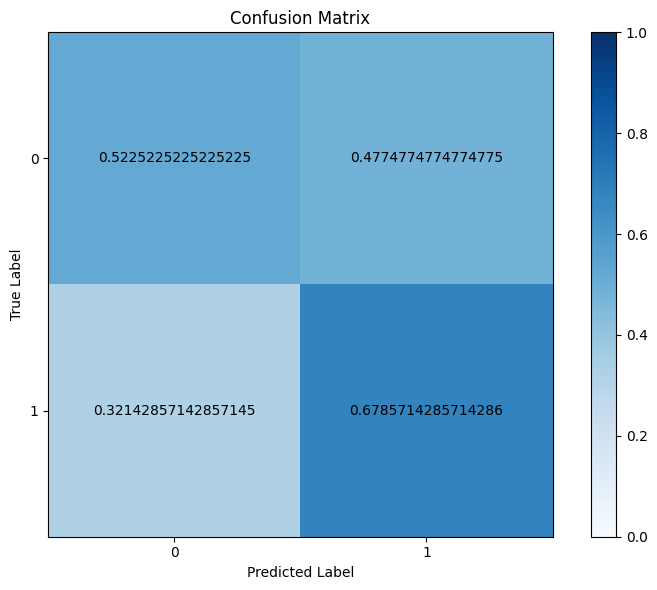

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7254 - loss: 0.7812 - val_accuracy: 0.2246 - val_loss: 1.1118
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6583 - loss: 0.8255 - val_accuracy: 0.4203 - val_loss: 0.7809
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6800 - loss: 0.7886 - val_accuracy: 0.6159 - val_loss: 0.6376
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6814 - loss: 0.7598 - val_accuracy: 0.7391 - val_loss: 0.5753
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6312 - loss: 0.7920 - val_accuracy: 0.7536 - val_loss: 0.5652
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6843 - loss: 0.7830 - val_accuracy: 0.7464 - val_loss: 0.5722
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7228 - loss: 0.7680 - val_accuracy: 0.7681 - val_loss: 0.5768
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6933 - loss: 0.7789 - val_accuracy: 0.7681 - val_loss: 0.5787
Epoch 9

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

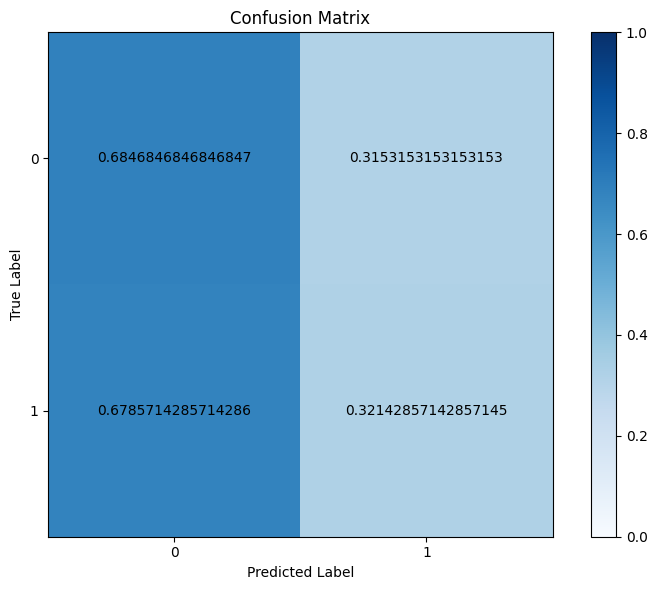

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [4]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42)